In [1]:
# Parameters
name = "J0806+2006"
z_lens = 0.573
z_source = 1.54


In [2]:
import pickle
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import h5py
import corner
import numpy as np

filter = "F814W"
filename = f"../hst_doubles/cutout_data/{name}/{filter}/{name}_{filter}.pkl"

# load the saved data
with open(filename, "rb") as f:
    loaded_data = pickle.load(f)

kwargs_result = loaded_data["kwargs_result"]
kwargs_model = loaded_data["kwargs_model"]
chain_list = loaded_data.get('chain_list')
kwargs_constraints = loaded_data.get("kwargs_constraints", None)


kwargs_lens = kwargs_result['kwargs_lens']
kwargs_ps = kwargs_result['kwargs_ps']

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, kwargs_fixed_lens=[{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}],
               kwargs_fixed_lens_light=[{}], kwargs_fixed_source=[{}], kwargs_fixed_ps=[{}], **kwargs_constraints)

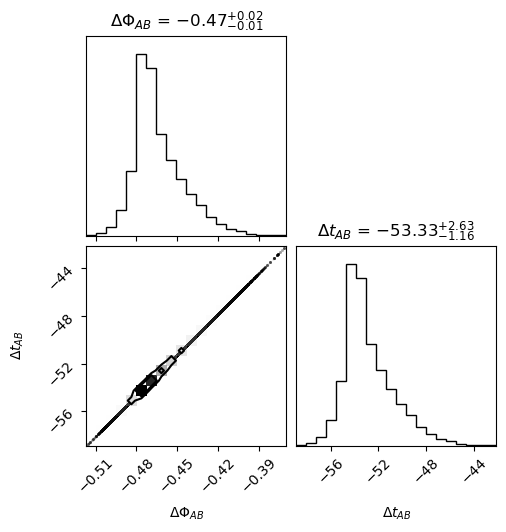

In [3]:
import numpy as np
import corner

dphi_list = []
dt_list = []
mcmc_new_list = []
labels_new = [r"$\Delta \Phi_{AB}$", r"$\Delta t_{AB}$"]

for i in range(len(samples_mcmc)):
    # Convert MCMC sample to kwargs
    kwargs_result = param.args2kwargs(samples_mcmc[i])

    # Compute Fermat potential
    fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    delta_fermat_12 = fermat_pot[0] - fermat_pot[1]

    # Compute time delays
    t_days = td_cosmo.time_delays(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'], kappa_ext=0)
    dt = t_days[0] - t_days[1]  # scalar value

    # Store values
    mcmc_new_list.append([delta_fermat_12, dt])
    dphi_list.append(delta_fermat_12)
    dt_list.append(dt)

# Plot corner plot
plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)

In [4]:
# save the final products in HDF5 format
with h5py.File(f'cutout_data/{name}/{filter}/{name}_{filter}_cosmo.hdf5', 'w') as f:
            f.create_dataset('dphi_list', data=np.array(dphi_list))
            f.create_dataset('dt_list', data=np.array(dt_list))
